# Stores-Item demand forecasting by XGBoost
## 1. Preparations

Import related libraries, 
Set up global constants and Hyper parameters for XGBoost,
Load train and test datasets.

### 1.1 Import Libraries

In [26]:
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import copy

### 1.2 Set up global constants and variables

In [27]:
DATASET_PATH = "/kaggle/input/demand-forecasting-kernels-only/"
TRAIN_FILENAME = "train.csv"
TEST_FILENAME = "test.csv"
TRAIN_FILEPATH = DATASET_PATH + TRAIN_FILENAME
TEST_FILEPATH = DATASET_PATH + TEST_FILENAME

# Attributes related to training/test data
LABEL = "sales"
COLUMN_DATE = "date"
COLUMN_ID = "id"
# orignial features
FEATURE_STORE = "store"
FEATURE_ITEM = "item"
# created features
FEATURE_DATE_YEAR = "year"
FEATURE_DATE_MONTH = "month"
FEATURE_DATE_QUARTER = "quarter"
FEATURE_DATE_DAYOFWEEk = "dayofweek"
FEATURE_DATE_DAYOFYEAR = "dayofyear"
FEATURE_DATE_IS_MONTH_START = "is_month_start"
FEATURE_DATE_IS_MONTH_END = "is_month_end"

# For lag features
LAGS = [
    7, # 1 week
    30, # 1 month
    90, # 1 quarter, (max-min) of test dates
    180, # a half year
    365, # a complete year
]

# For Rolling Features
MIN_PERIODS = 15 # half of month due to win_type
WINDOWS = [
    90, # 1 quarter, (max-min) of test dates + MIN_PERIODS
    180, # a half year + MIN_PERIODS
    365, # a complete year + MIN_PERIODS
]
WIN_TYPE = "triang"


# initial featuren name collection
all_feature_names = [
    FEATURE_STORE,
    FEATURE_ITEM,
    FEATURE_DATE_YEAR,
    FEATURE_DATE_MONTH,
    FEATURE_DATE_QUARTER,
    FEATURE_DATE_DAYOFWEEk,
    FEATURE_DATE_DAYOFYEAR,
    FEATURE_DATE_IS_MONTH_START,
    FEATURE_DATE_IS_MONTH_END,
]


NDIGITS = 4 # precison of round() method
N_SPLITS = 5 # for Kfold

COLOR_PAL = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
plt.style.use(style="fivethirtyeight")

### 1.3 Set up Hyper parameters

In [28]:

## General Parameters

BOOSTER = "gbtree" # gbtree and dart use tree based; gblinear use linear funcitons
DEVICE = "cuda" # cuda, gpu or cpu
VALIDATE_PARAMETERS = True # perform validation of input parameters to check whether a parameter is used or not.
DISABLE_DEFEAULT_EVAL_METRIC = True # use customized sample instead.

## Parameters for Tree Booster

ETA = 0.3 # default 0,3, learning_rate
GAMMA = 0 # default 0, min_split_loss, The larger the more conservative algorithm is.
MAX_DEPTH = 6 # default 6, 0 indicates no limit on depth.
# defalut 1, In regression task, simply corresponds to minimum number of instances in each node.
# The larger hte more conservative
MIN_CHILD_WEIGHT = 1 
# # default 0, positive to help making the update step more conservative.
# #it might help in logistic regression when class is extremely imbalanced.
# MAX_DELTA_STEP = 0 
SUBSAMPLE = 0.5 # default 1, range(0,1], this prevent overfitting
COLSAMPLE_BYTREE = 0.8 # range(0,1]
# LAMBDA = 1 #default 1, alias: reg_lambda, L2 regularization term on weights increase to make more conservative
# ALPHA = 0 #defalut 0, L1 regularization term on weights
TREE_METHOD = "hist" # tree method of xgboost: auto=hist, exact, approx, hist

## Learning Task Parameters

OBJECTIVE = "reg:squarederror" # objective of learning task
NUM_BOOST_ROUND = 10 # default 10, equivalent to number of gradient boosted trees.
EARLY_STOPPING_ROUNDS = 10
RANDOM_STATE = 214

## Booster parameters of XGBoost model

xgb_params = {
    'booster': BOOSTER,
    'device': DEVICE,
    'validate_parameters': VALIDATE_PARAMETERS,
    'disable_default_eval_metric': DISABLE_DEFEAULT_EVAL_METRIC,
    'objective': OBJECTIVE,
    'min_child_weight': MIN_CHILD_WEIGHT,
    # 'max_delta_step': MAX_DELTA_STEP,
    'subsample': SUBSAMPLE,
    'colsample_bytree': COLSAMPLE_BYTREE,
    # 'lambda': LAMBDA,
    # 'alpha': ALPHA,
    'tree_method': TREE_METHOD,
}


## Parameters for XGBoost cross validation: xgb.cv()

NFOLD = 5
STRATIFIED = False # perform stratified sampling
SHUFFLE = False
AS_PANDAS = True # Return pd.DataFrame

# Parmaeters for BayesianSearchCV

CV = 3


### 1.4 Load Train and Test datasets

In [29]:
train_df = pd.read_csv(TRAIN_FILEPATH, parse_dates=[COLUMN_DATE], index_col=COLUMN_DATE)
test_df = pd.read_csv(TEST_FILEPATH, parse_dates=[COLUMN_DATE], index_col=COLUMN_DATE)
raw_data_concact_df = pd.concat([train_df, test_df])

## 2 Feature Engineering

1. Time Features, 
2. Lag Features, 
3. Rolling Features
4. One-Hot coding for categorical Features

In [30]:
def create_features(raw_df: pd.DataFrame, label:str = None):
    def create_time_features(data_df: pd.DataFrame):
        data_df[FEATURE_DATE_YEAR] = data_df.index.year
        data_df[FEATURE_DATE_MONTH] = data_df.index.month
        data_df[FEATURE_DATE_QUARTER] = data_df.index.quarter
        data_df[FEATURE_DATE_DAYOFYEAR] = data_df.index.dayofyear
        data_df[FEATURE_DATE_DAYOFWEEk] = data_df.index.dayofweek
        data_df[FEATURE_DATE_IS_MONTH_START] = (data_df.index.is_month_start).astype(int)
        data_df[FEATURE_DATE_IS_MONTH_END] = (data_df.index.is_month_end).astype(int)
        
    def create_lag_features(data_df: pd.DataFrame):
        for lag in LAGS:
            feature_name = "sales_lag_" + str(lag)
            all_feature_names.append(feature_name)
            data_df[feature_name] = \
                data_df.groupby(by=[FEATURE_STORE, FEATURE_ITEM])[LABEL].\
                    shift(periods=lag)
                
    def create_rolling_mean_features(data_df: pd.DataFrame):
        for window in WINDOWS:
            feature_mean_name = "sales_rolling_mean_" + str(window)
            feature_median_name = "sale_rolling_median_" + str(window)
            all_feature_names.append(feature_mean_name)
            all_feature_names.append(feature_median_name)
            
            data_df[feature_mean_name] = \
                data_df.groupby(by=[FEATURE_STORE, FEATURE_ITEM])[LABEL].\
                    transform(lambda x: x.rolling(window=window, min_periods = MIN_PERIODS, win_type = "triang").mean())
            data_df[feature_median_name] = \
                data_df.groupby(by=[FEATURE_STORE, FEATURE_ITEM])[LABEL].\
                    transform(lambda x: x.rolling(window=window, min_periods = MIN_PERIODS).median())
    
    
    data_df = copy.deepcopy(raw_df)
    create_time_features(data_df)
    # create_lag_features(data_df)
    # create_rolling_mean_features(data_df)

    X_data = data_df.loc[:, all_feature_names]
    
    if label:
        y_data = raw_df[label]
        return data_df, X_data, y_data
    else:
        return data_df, X_data
    
data_df, X_data, y_data = create_features(raw_data_concact_df, label=LABEL)

In [31]:
data_df

,store,item,sales,id,year,month,quarter,dayofyear,dayofweek,is_month_start,is_month_end
date,,,,,,,,,,,
2013-01-01,1,1,13.0,NaN,2013,1,1,1,1,1,0
2013-01-02,1,1,11.0,NaN,2013,1,1,2,2,0,0
2013-01-03,1,1,14.0,NaN,2013,1,1,3,3,0,0
2013-01-04,1,1,13.0,NaN,2013,1,1,4,4,0,0
2013-01-05,1,1,10.0,NaN,2013,1,1,5,5,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2018-03-27,10,50,NaN,44995.0,2018,3,1,86,1,0,0
2018-03-28,10,50,NaN,44996.0,2018,3,1,87,2,0,0
2018-03-29,10,50,NaN,44997.0,2018,3,1,88,3,0,0


## 3. Create the XGBoost model

### 3.1 Define customized metrics : smape

In [32]:
def smape(predt: np.ndarray, dtrain: xgb.DMatrix)->tuple[str, float]:
    y = dtrain.get_label()
    if not isinstance(y, np.ndarray):
        y = np.array(y)
    elements = np.abs(predt-y)/((np.abs(predt)+np.abs(y))*0.5)
    return 'smape', round(np.mean(elements)*100, ndigits=NDIGITS)

def smape_np(predt: np.ndarray, actual:np.ndarray)->float:
    elements = np.abs(predt-actual)/((np.abs(predt)+np.abs(actual))*0.5)
    return round(np.mean(elements)*100, ndigits=NDIGITS)

### 3.2 Data postprocessing

In [33]:
data_df.sort_index(inplace=True)

train_df = data_df.loc[~data_df.sales.isna()]
X_train = train_df[all_feature_names]
y_train = train_df[LABEL]

test_df = data_df[data_df.sales.isna()]
test_df.reset_index(inplace=True)
test_df.set_index(keys = [COLUMN_ID], inplace=True)
test_df = test_df.sort_index()
X_test = test_df[all_feature_names]

dtrain = xgb.DMatrix(data=X_train, label=y_train)

### 3.3 XGBoost cross validation
apply initial `xgb_params`

In [34]:
eval_historys = xgb.cv(
    params=xgb_params,
    dtrain=dtrain,
    num_boost_round=NUM_BOOST_ROUND,
    # early_stopping_rounds=EARLY_STOPPING_ROUNDS,
    nfold=NFOLD,
    seed=RANDOM_STATE,
    stratified=STRATIFIED,
    as_pandas=AS_PANDAS,
    shuffle=SHUFFLE,
    custom_metric=smape,
)

eval_historys

,train-smape-mean,train-smape-std,test-smape-mean,test-smape-std
0,42.73656,0.289036,43.21486,2.426014
1,40.61984,0.285952,41.28334,2.141260
2,36.63534,0.426907,37.52406,2.529949
3,33.82040,0.432106,34.86862,2.747020
4,31.84726,0.452355,32.99018,2.755674
5,30.60646,0.402229,31.81370,2.772734
6,29.72114,0.376813,30.87820,2.409690
7,29.14582,0.354265,30.32298,2.365949
8,27.04118,0.993388,28.52566,2.021125
9,26.66614,0.995722,27.99054,1.608769


In [35]:
xgb_regressor = \
    xgb.XGBRegressor(**xgb_params,
                    n_estimators = NUM_BOOST_ROUND,
                    eval_metric = smape,
                    random_state = RANDOM_STATE
                    )

xgb_regressor.fit(X_train,y_train)

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device='cuda',
             disable_default_eval_metric=True, early_stopping_rounds=None,
             enable_categorical=False,
             eval_metric=<function smape at 0x0000015340899080>,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=10,
             n_jobs=None, num_parallel_tree=None, ...)

In [36]:
predictions = xgb_regressor.predict(X_train)
print("SMAPE score:",smape_np(y_train,predictions))

SMAPE score: 26.4905


In [37]:

from skopt import BayesSearchCV

tune_params_grid = {
    'max_depth': np.arange(3,12,1),
    'min_child_weight': np.arange(0.05, 1.0, 0.05),
    'gamma': np.arange(0.0,5,0.05),
    'learning_rate': np.arange(0.05,0.3,0.005),
    'subsample': np.arange(0.5,1.0,0.05),
    'colsample_bytree': np.arange(0.5,1.0,0.05),
}

tuned_xgb = \
    BayesSearchCV(
        xgb_regressor,
        tune_params_grid,
        cv=CV,
        scoring='neg_mean_squared_error',
        random_state=RANDOM_STATE
    )
    
tuned_xgb.fit(X_train,y_train)

BayesSearchCV(cv=3,
              estimator=XGBRegressor(base_score=None, booster='gbtree',
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, device='cuda',
                                     disable_default_eval_metric=True,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric=<function smape at 0x0000015340899080>,
                                     feature_types=None, gamma=None,
                                     grow_policy=None,...
       0.185, 0.19 , 0.195, 0.2  , 0.205, 0.21 , 0.215, 0.22 , 0.225,
       0.23 , 0.235, 0.24 , 0.245, 0.25 , 0.255, 0.26 , 0.265, 0.27 ,
       0.275, 0.28 , 0.285, 0.29 , 0.295]),
                             'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11]),
                             'min_child_weight': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95]),
                             'subsample': array([0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])})

In [39]:
bst = tuned_xgb.best_estimator_.get_booster()

In [ ]:

# kfold = KFold(n_splits=N_SPLITS, shuffle=SHUFFLE)

# for i,(train_index,validation_index) in enumerate(kfold.split(X=X_train,y=y_train)):
#     dtrain = xgb.DMatrix(data = X_train.iloc[train_index, :], label = y_train.iloc[train_index])
#     dval = xgb.DMatrix(data=X_train.iloc[validation_index, :], label = y_train.iloc[validation_index])
    
#     evals_result = {}
#     watch_list = [
#         (dtrain,"dtrain"), 
#         (dval, "dval"),
#     ]
    
#     bst = xgb.train(
#         params = xgb_params, 
#         dtrain = dtrain, 
#         num_boost_round=NUM_BOOST_ROUND,
#         early_stopping_rounds=EARLY_STOPPING_ROUNDS,
#         evals = watch_list,
#         evals_result = evals_result,
#         custom_metric= smape,
#     )

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

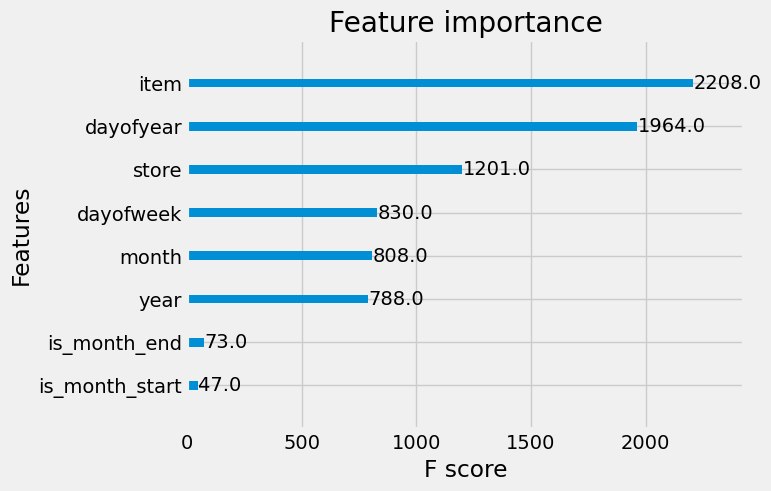

In [40]:
xgb.plot_importance(
    booster=bst
)

In [41]:
dtest = xgb.DMatrix(data=X_test)
predictions = bst.predict(dtest)
test_df[LABEL] = predictions

In [42]:
submission_df = test_df.loc[:,[LABEL]]
submission_df.index = submission_df.index.astype(int)
submission_df.to_csv("submission.csv", index=True)